In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import q_stat
from matplotlib import colors


In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [4]:
import os

# Get the current PATH
path = os.environ.get('PATH')

# Add your LaTeX path to it
new_path = "/home/hp364/texlive/2023/bin/x86_64-linux/:" + path

# Set the new PATH
os.environ['PATH'] = new_path


In [5]:
workingdir='/share/kim/STEM_sample_2/'
f=h5py.File(workingdir+'data.hdf5','r')
I,T=f['I'],f['T']

In [6]:
x,y=60,60
T_idx=0

In [7]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)
plt.rcParams['text.latex.preamble']=r'\usepackage{amsmath,amssymb,physics,bm}'

# Count peaks

In [8]:
q=q_stat.q_stat(T_idx,x,y,workingdir,auto=True,)

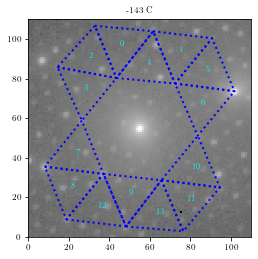

In [9]:
q.visualize_grid(remove_central_shell=True)

{'mean': 5.357142857142857,
 'std': 0.8112726208286104,
 'length': 14,
 'bragg': array([[  8.29392676,  18.38852217],
        [  4.75088895,  47.79563704],
        [  2.34953933,  76.00652303],
        [ 35.01628828,   7.76098382],
        [ 31.34049174,  36.66857608],
        [ 28.1457439 ,  65.2620799 ],
        [ 24.50529218,  94.06712391],
        [ 58.30683054,  26.02101401],
        [ 54.21955174,  54.33393037],
        [ 50.59726282,  83.11967023],
        [ 85.32363532,  14.00746666],
        [ 79.85392191,  43.08708502],
        [ 77.06060408,  71.92261816],
        [ 73.18369647, 101.2593875 ],
        [106.2576585 ,  32.44214286],
        [103.48149552,  61.17526551],
        [ 99.9791485 ,  90.21931745]])}

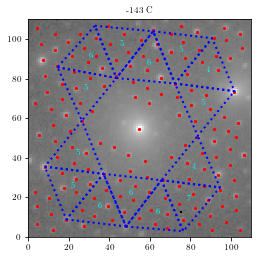

In [10]:
q.count_pts(visualization=True,repel=np.sqrt(2),remove_central_shell=True)

In [11]:
metrics=q.count_pts(visualization=False,repel=np.sqrt(2),remove_central_shell=True)

In [14]:
def plot_count_pts(q,ax=None,ax_inset=None,s=5):
    centroid=q._centroid()


    if ax is None:
        fig,ax=plt.subplots(figsize=(4,4))
    
    
    
    data_linear=10**q.logdata
    vmin,vmax=np.min(data_linear),np.max(data_linear)
    im=ax.pcolormesh(data_linear,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax),rasterized=True)
    ax.scatter(q.mask_ind[:,1]+0.5,q.mask_ind[:,0]+0.5,s=s,color='r')
    if ax_inset is not False:
        if ax_inset is None:
            ax_inset = ax.inset_axes([0.5, 1.05, 0.5, 0.08])
            ax_inset.xaxis.tick_top()
            ax_inset.xaxis.set_label_position('top')
            
        plt.colorbar(im,cax=ax_inset,orientation='horizontal')
        ax_inset.xaxis.tick_top()
        ax_inset.xaxis.set_label_position('top')


    line=[]
    for triangle in q.bragg_triangle_list:
        for i in range(3):
            pts1=triangle[i]
            pts2=triangle[(i+1)%3]
            pts=(tuple(pts1.tolist()),tuple(pts2.tolist()))
            line.append(pts)
    
    for pth in set(line):
        ax.plot(np.array(pth)[:,1]+0.5,np.array(pth)[:,0]+0.5,color='blue',lw=2,ls='dotted')
    inside_num,contains_pts=q_stat._is_inside(q.bragg_triangle_list,q.mask_ind,repel=1.4)
    for idx, cor in zip(inside_num, centroid):
        ax.text(cor[1],cor[0],'{:.0f}'.format(idx),color='cyan',fontsize=8) 
    ax.set_xticks([])
    ax.set_yticks([])


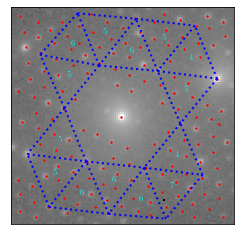

In [16]:
# fig,ax=plt.subplots(figsize=(4,4))
plot_count_pts(q,s=2,ax_inset=False)

# Cluster

In [17]:
import pickle
# from GMM import *
from GMM import GMM_model, scoring

In [18]:
with open('Fig/count_pts_outlier_auto.pickle','rb') as f:
    count_pts_outlier_auto=pickle.load(f)

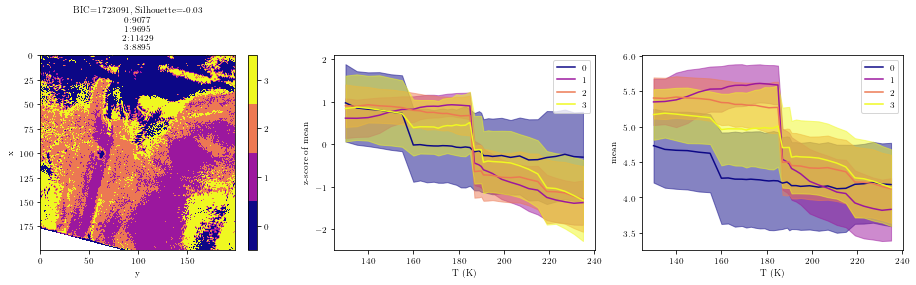

In [19]:
fig,ax=plt.subplots(1,3,figsize=(13,4),tight_layout=True)

count_pts_outlier_auto.GMM_plot('mean',[0,1,2,3],ax=ax)

## Phase diagram

In [20]:
def plot_phasediagram(model,ax=None):
    if ax is None:
        ig,ax= plt.subplots()
    labels_=model.labels_['mean']
    cmap = plt.get_cmap('plasma', model.k)
    bounds = np.arange(model.k+1)-0.5
    norm = colors.BoundaryNorm(bounds, cmap.N)
    ax.imshow(model.labels_grid['mean'],cmap=cmap,norm=norm,extent=(model.rs['y'][0],model.rs['y'][-1],model.rs['x'][-1],model.rs['x'][0]),rasterized=True)
    ax.set_xticks([])
    ax.set_yticks([])

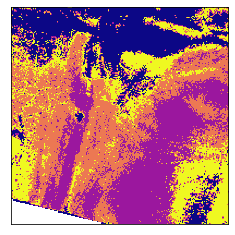

In [21]:
plot_phasediagram(count_pts_outlier_auto)

## trend

In [22]:
def plot_trend(model,ax=None,method='std',**kwargs):
    if ax is None:
        ig,ax= plt.subplots()
    cmap = plt.get_cmap('plasma', model.k)
    color_list=[cmap(idx) for idx in range(model.k)]
    labels_=model.labels_['mean']
    for n,color in zip(range(model.k),color_list):
        mean=model.X_orig['mean'][labels_==n].T.mean(axis=-1)
        ax.plot(model.rs['T'][model.mask_T],mean,color=color,label=str(n),**kwargs)
        if method == 'std':
            error=model.X_orig['mean'][labels_==n].T.std(axis=-1)
            lb=mean-error
            ub=mean+error
        elif method== 'percentile':
            lb=np.percentile(model.X_orig['mean'][labels_==n],25,axis=0)
            ub=np.percentile(model.X_orig['mean'][labels_==n],75,axis=0)
        else:
            raise ValueError(f'method {method} not defined')
        ax.fill_between(model.rs['T'][model.mask_T],lb,ub,color=color,alpha=0.5)
    ax.set_xticks(range(130,230,30))
    ax.set_yticks([3,4,5,6])
    ax.set_ylabel('Peak number')
    ax.set_xlim(T[0]+273,T[-1]+273)

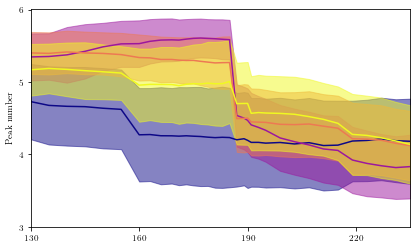

In [23]:
plot_trend(count_pts_outlier_auto,method='std')

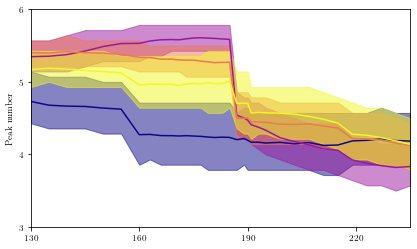

In [24]:
plot_trend(count_pts_outlier_auto,method='percentile')

# R vs T

In [25]:
cond=np.load(workingdir+'/RvT.npy')
cond_K=cond+np.array([273,0])

In [26]:
def plot_R_vs_T(cond_K,ax=None,**kwargs):
    if ax is None:
        fig,ax= plt.subplots()
    ax.plot(cond_K[:,0],cond_K[:,1]/1e3,color='k',**kwargs)
    ax.set_xlabel('$T$ (K)')
    ax.set_ylabel('$R$ (k$\Omega$)')
    ax.set_xticks(range(130,230,30))
    ax.set_xlim(cond_K[0,0],cond_K[-1,0])

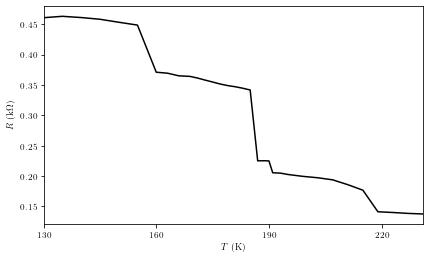

In [27]:
plot_R_vs_T(cond_K)

# Example 

In [28]:
filename_cluster_ave='ave_cluster_real_space_outlier_no_vac.pickle'

In [29]:
with open(filename_cluster_ave,'rb') as f:
    rs=pickle.load(f)

In [30]:
T[:]+273

array([130, 135, 140, 145, 150, 155, 160, 163, 166, 169, 171, 173, 175,
       177, 179, 181, 183, 185, 187, 189, 190, 191, 193, 195, 199, 203,
       207, 211, 215, 219, 223, 227, 231, 235])

In [31]:
rs[(0,160)]

array([[40866.582, 39374.543, 39210.066, ..., 40418.438, 39180.754,
        37970.812],
       [46319.84 , 41099.77 , 39680.316, ..., 39026.855, 38245.914,
        37691.66 ],
       [50851.32 , 42194.992, 40570.36 , ..., 38996.195, 38036.57 ,
        37534.793],
       ...,
       [39105.46 , 39678.46 , 40257.55 , ..., 44688.156, 44443.47 ,
        45981.098],
       [39702.46 , 39821.094, 40543.844, ..., 44432.168, 44273.465,
        45965.78 ],
       [40516.39 , 40172.777, 41109.84 , ..., 44384.043, 43881.53 ,
        44426.492]], dtype=float32)

In [32]:
def plot_diffraction(data,idx,ax=None):

    if ax is None:
        fig,ax=plt.subplots(figsize=(4,4))
    cmap = plt.get_cmap('plasma', 4)
    vmin,vmax=np.min(data),np.max(data)
    im=ax.pcolormesh(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax),rasterized=True)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor(cmap(idx))
        spine.set_linewidth(2)


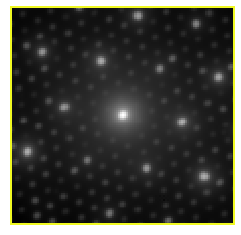

In [33]:
plot_diffraction(rs[(1,160)],idx=4)

# CDW angle

In [34]:
angle=[np.load(f'angle/cluster_{idx}_phi.npy') for idx in range(4)]
angle_err=[np.load(f'angle/cluster_{idx}_phi_error.npy') for idx in range(4)]

In [35]:
def plot_CDW_angle(angle,ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    cmap = plt.get_cmap('plasma', 4)
    color_list = [cmap(idx) for idx in range(4)]

    for i in range(4):
        ax.plot(T[:]+273, np.abs(angle[i]), label=f'Cluster {i}', color=color_list[i])
        ax.fill_between(T[:]+273, np.abs(angle[i]) - angle_err[i], np.abs(angle[i]) + angle_err[i],
                        color=color_list[i], alpha=0.5)

    ax.set_xlabel("$T$ (K)")
    ax.set_ylabel(r"$\theta^{\circ}$",labelpad=-3)
    # ax.legend()
    ax.axhline(y=13.9,lw=1,ls='dashed',color='k')
    ax.set_yticks(np.arange(13.9,12.1,-0.5))
    ax.set_xticks(range(130,230,30))
    ax.set_xlim(T[0]+273,T[-1]+273)

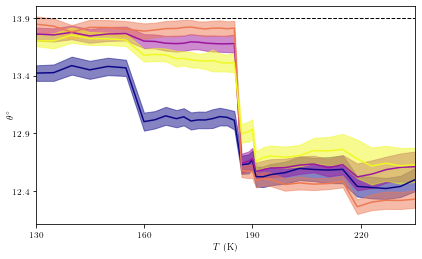

In [36]:
plot_CDW_angle(angle)

# Bright field image

In [37]:
data_mean=I[0].mean(axis=(2,3))

In [38]:
def plot_BF(data,ax=None,ax_inset=None):
    if ax is None:
        fig,ax= plt.subplots()
    
        
    vmin,vmax=data.min(),data.max()
    im=ax.imshow(data,cmap='gray', norm=colors.LogNorm(vmin=vmin, vmax=vmax),rasterized=True)
    if ax_inset is not False:
        if ax_inset is None:
            ax_inset = ax.inset_axes([0.5, 1.05, 0.5, 0.1])
        cb=plt.colorbar(im,cax=ax_inset,orientation='horizontal')
        ax_inset.xaxis.tick_top()
        ax_inset.xaxis.set_label_position('top')

    ax.set_xticks([])
    ax.set_yticks([])
    


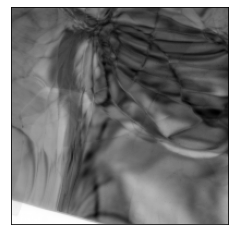

In [39]:
plot_BF(data_mean,ax_inset=False)

# Generate frame

In [7]:
!which pdflatex

/home/hp364/texlive/2023/bin/x86_64-linux//pdflatex


In [41]:
def generate_frame(width = 6.8 , wspace = 0.4, hspace = 0.2, distance2 = 0.15, hspace2 = 0.1, width_ratios = [1,  1, 1] , height_ratios = [1, 1] , clip=(.5,.15,.3,.35),nudge = 0.03):
    clip_left,clip_right,clip_top,clip_bottom=clip
    

    # calculate the height based on your calculation
    height = (width-clip_right-clip_left) / (np.sum(width_ratios) + wspace * 2) * 2 + hspace+ clip_top+ clip_bottom

    # Set up the figure and the main axes
    fig, axs = plt.subplots(2,3,figsize=(width, height),
                            gridspec_kw={
                                'wspace': wspace,
                                'hspace': hspace,
                                'width_ratios': width_ratios,
                                'height_ratios': height_ratios
                            })
    plt.subplots_adjust(left=(clip_left)/fig.get_size_inches()[0], right=1-(clip_right)/fig.get_size_inches()[0],bottom=(clip_bottom)/fig.get_size_inches()[1], top=1-(clip_top)/fig.get_size_inches()[1])
    for i in [0, 1]:  # for both rows
        box = axs[i, 2].get_position()
        box.x0 = box.x0 - nudge  # adjust left position
        box.x1 = box.x1 - nudge  # adjust right position
        axs[i, 2].set_position(box)
        
    # Additional panels
    # Inset axis for axs[0, 0]
    axs_inset0 = axs[0, 0].inset_axes([0.5, 1.05, 0.5, 0.08])
    axs_inset0.xaxis.tick_top()
    axs_inset0.xaxis.set_label_position('top')

    # Invisible inset to the right of axs[0, 2]
    width_inset_ax = (np.sum(height_ratios) + hspace - 3 * hspace2) / 4
    axs_diff = [axs[1, 2].inset_axes([
        1 + distance2, (width_inset_ax+hspace2)* (3-i) , width_inset_ax,
        width_inset_ax 
    ],transform=axs[1, 2].transAxes) for i in range(4)]

    # Make the inset axis invisible
    [ax.set_xticks([]) for ax in axs_diff]
    [ax.set_yticks([]) for ax in axs_diff]

    # Inset axis for axs[1, 2]
    axs_inset1 = axs[1, 2].inset_axes([0.5, 1.05, 0.5, 0.08])
    axs_inset1.xaxis.tick_top()
    axs_inset1.xaxis.set_label_position('top')

    


    return fig, axs, axs_diff, axs_inset0, axs_inset1





(<Figure size 489.6x276.8 with 6 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 [<Axes:label='inset_axes'>,
  <Axes:label='inset_axes'>,
  <Axes:label='inset_axes'>,
  <Axes:label='inset_axes'>],
 <Axes:label='inset_axes'>,
 <Axes:label='inset_axes'>)

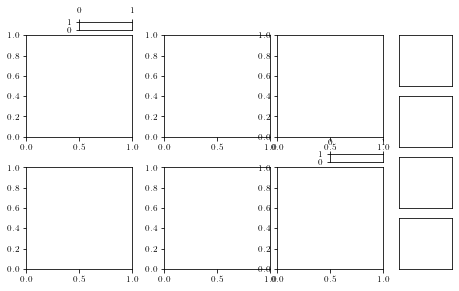

In [11]:
generate_frame(hspace=0.3,wspace=0.3,clip=(.5,1,.2,.4),nudge=0.05)


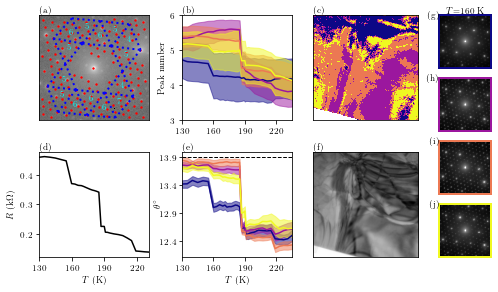

In [43]:
fig, axs, axs_diff, axs_inset0, axs_inset1= generate_frame(hspace=0.3,wspace=0.3,distance2=0.2,clip=(.5,.8,.2,.4),nudge=0.03)
axs_inset0.set_visible(False)
axs_inset1.set_visible(False)

plot_count_pts(q,ax=axs[0,0],ax_inset=False,s=2)
plot_trend(count_pts_outlier_auto,ax=axs[0,1])
plot_phasediagram(count_pts_outlier_auto,ax=axs[0,2])
plot_R_vs_T(cond_K,ax=axs[1,0])

plot_CDW_angle(angle,ax=axs[1,1])

plot_BF(data_mean,ax=axs[1,2],ax_inset=False)

for i in range(4):
    plot_diffraction(rs[(i,160)],idx=i,ax=axs_diff[i])
axs_diff[0].text(.5,1,r'$T$=160 K',ha='center',va='bottom',transform=axs_diff[0].transAxes)

[ax.text(0,1,f'({text})',ha='left',va='bottom',transform=ax.transAxes) for text, ax in zip('abcdef',axs.flatten())]
[ax.text(0,1,f'({text})',ha='right',va='center',transform=ax.transAxes) for text, ax in zip('ghij',axs_diff)]


fig.savefig('Fig3.png',dpi=300)

-[x] axs[0,0] colorbar axis  
-[x] axs[1,0] ticklabels  
-[ ] change the subplots_adjust  

# Here all used T=lowest temp